- RNN: Recurrent Neural Network
- LSTM: Long Short Term Memory
- ES: Early Stopping
- Multi-Step time series forecasting
- Univariate (only input its own price)

In [1]:
# parameters
n_past_total = 1200 #1500 #2000
n_past = 100 #50
prediction_days = 7
activation = 'softsign' #'softsign' #'relu' #'sigmoid'
dropout = 0.1
n_layers = 3 #hidden layers (without counting the first one and the last one)
n_neurons = 10 #neurons of hidden layers
n_features = 1
patience = 200

In [2]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from keras.models import Sequential, load_model
from keras.layers import Dense, LSTM, Dropout
from sklearn.preprocessing import MinMaxScaler
pd.set_option('display.float_format', lambda x: '%.3f' % x) #avoid scientific notation
import datetime
import math
from sklearn.metrics import mean_squared_error, mean_absolute_error, explained_variance_score
from keras.callbacks import EarlyStopping
import seaborn as sns

In [3]:
# reading csv
dataset = pd.read_csv('yahoo_BTC-USD.csv')
dataset

,Date,Open,High,Low,Close,Adj Close,Volume
0,2014-09-17,465.864,468.174,452.422,457.334,457.334,21056800.000
1,2014-09-18,456.860,456.860,413.104,424.440,424.440,34483200.000
2,2014-09-19,424.103,427.835,384.532,394.796,394.796,37919700.000
3,2014-09-20,394.673,423.296,389.883,408.904,408.904,36863600.000
4,2014-09-21,408.085,412.426,393.181,398.821,398.821,26580100.000
...,...,...,...,...,...,...,...
2449,2021-06-01,37293.793,37896.734,35787.086,36684.926,36684.926,34639423297.000
2450,2021-06-02,36699.922,38231.340,35966.309,37575.180,37575.180,33070867190.000
2451,2021-06-03,37599.410,39478.953,37243.973,39208.766,39208.766,35460750427.000
2452,2021-06-04,39242.484,39242.484,35717.723,36894.406,36894.406,41831090187.000


In [4]:
dataset[['Close','Volume']].corr()

,Close,Volume
Close,1.000,0.798
Volume,0.798,1.000


In [5]:
# checking if close is not equal to adj close
dataset[dataset['Close']!=dataset['Adj Close']]

,Date,Open,High,Low,Close,Adj Close,Volume
2039,2020-04-17,nan,nan,nan,nan,nan,nan
2214,2020-10-09,nan,nan,nan,nan,nan,nan
2217,2020-10-12,nan,nan,nan,nan,nan,nan
2218,2020-10-13,nan,nan,nan,nan,nan,nan


In [6]:
# checking for nulls
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2454 entries, 0 to 2453
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       2454 non-null   object 
 1   Open       2450 non-null   float64
 2   High       2450 non-null   float64
 3   Low        2450 non-null   float64
 4   Close      2450 non-null   float64
 5   Adj Close  2450 non-null   float64
 6   Volume     2450 non-null   float64
dtypes: float64(6), object(1)
memory usage: 134.3+ KB


In [7]:
dataset.describe()

,Open,High,Low,Close,Adj Close,Volume
count,2450.000,2450.000,2450.000,2450.000,2450.000,2450.000
mean,7626.843,7844.916,7387.271,7640.137,7640.137,12616231026.884
std,11665.490,12032.959,11232.481,11676.218,11676.218,19727883639.959
min,176.897,211.731,171.510,178.103,178.103,5914570.000
25%,460.801,466.735,455.070,460.719,460.719,68730922.000
50%,4324.400,4403.835,4138.012,4330.050,4330.050,4010640000.000
75%,9193.489,9355.582,9030.895,9203.736,9203.736,18684308124.500
max,63523.754,64863.098,62208.965,63503.457,63503.457,350967941479.000


In [8]:
# use close only and fill NaN with ffil
#n_past_total = 1500 #2000
df = dataset.set_index('Date')[['Close']].tail(n_past_total)
df = df.set_index(pd.to_datetime(df.index))
df.fillna(method='ffill',inplace=True)

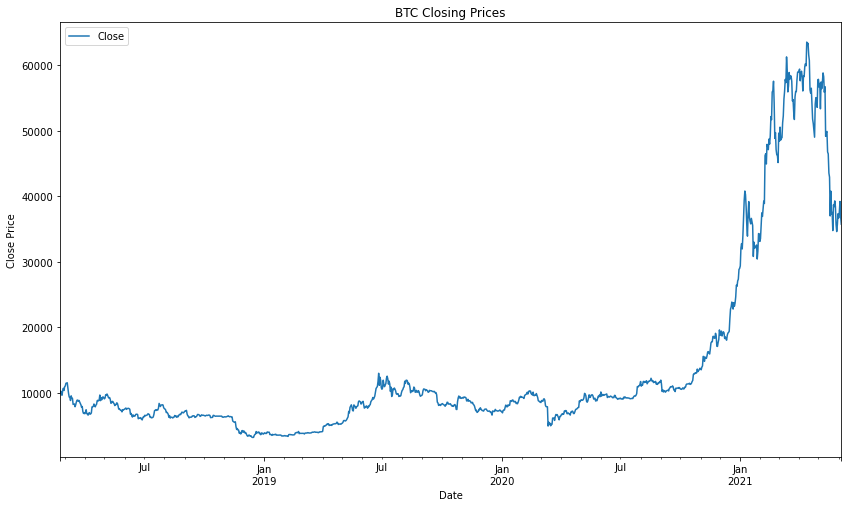

In [9]:
# plotting the Closing Prices
df.plot(figsize=(14,8))
plt.title('BTC Closing Prices')
plt.ylabel('Close Price')
plt.show()

In [10]:
# train test split
#prediction_days = 10
df_train = df.head(-prediction_days)
df_test = df.tail(prediction_days)
training_set = df_train.values
test_set = df_test.values
print('training_set.shape = ', training_set.shape)
print('test_set.shape = ', test_set.shape)

training_set.shape =  (1193, 1)
test_set.shape =  (7, 1)


In [11]:
# scale
sc = MinMaxScaler(feature_range=(0,1))
training_set_scaled = sc.fit_transform(training_set)
print('training_set_scaled.shape', training_set_scaled.shape)
training_set_scaled

training_set_scaled.shape (1193, 1)


array([[0.11230479],
       [0.11721794],
       [0.10912011],
       ...,
       [0.58407395],
       [0.53861994],
       [0.52067406]])

In [12]:
# creating a data structure with 60 timesteps and 1 output
X_train = []
y_train = []
 
#n_future = prediction_days #20  # Number of days you want to predict into the future
#n_past = 50  # Number of past days you want to use to predict the future

for i in range(n_past, len(training_set_scaled) - prediction_days + 1):
    X_train.append(training_set_scaled[i-n_past:i, 0])
    y_train.append(training_set_scaled[i:i+prediction_days, 0])

X_train, y_train = np.array(X_train), np.array(y_train)

In [13]:
X_train.shape, y_train.shape

((1087, 100), (1087, 7))

In [14]:
range(n_past, len(training_set_scaled) - prediction_days + 1)

range(100, 1187)

In [15]:
range(n_past, len(training_set_scaled)-7)

range(100, 1186)

In [16]:
for i in range(n_past, len(training_set_scaled) - prediction_days + 1):
    print('i={}, [{}, {})'.format(i, i-n_past, i))

i=100, [0, 100)
i=101, [1, 101)
i=102, [2, 102)
i=103, [3, 103)
i=104, [4, 104)
i=105, [5, 105)
i=106, [6, 106)
i=107, [7, 107)
i=108, [8, 108)
i=109, [9, 109)
i=110, [10, 110)
i=111, [11, 111)
i=112, [12, 112)
i=113, [13, 113)
i=114, [14, 114)
i=115, [15, 115)
i=116, [16, 116)
i=117, [17, 117)
i=118, [18, 118)
i=119, [19, 119)
i=120, [20, 120)
i=121, [21, 121)
i=122, [22, 122)
i=123, [23, 123)
i=124, [24, 124)
i=125, [25, 125)
i=126, [26, 126)
i=127, [27, 127)
i=128, [28, 128)
i=129, [29, 129)
i=130, [30, 130)
i=131, [31, 131)
i=132, [32, 132)
i=133, [33, 133)
i=134, [34, 134)
i=135, [35, 135)
i=136, [36, 136)
i=137, [37, 137)
i=138, [38, 138)
i=139, [39, 139)
i=140, [40, 140)
i=141, [41, 141)
i=142, [42, 142)
i=143, [43, 143)
i=144, [44, 144)
i=145, [45, 145)
i=146, [46, 146)
i=147, [47, 147)
i=148, [48, 148)
i=149, [49, 149)
i=150, [50, 150)
i=151, [51, 151)
i=152, [52, 152)
i=153, [53, 153)
i=154, [54, 154)
i=155, [55, 155)
i=156, [56, 156)
i=157, [57, 157)
i=158, [58, 158)
i=159, 

In [17]:
for i in range(n_past, len(training_set_scaled) - prediction_days + 1):
    print('i={}, [{}, {})'.format(i, i, i+prediction_days)) #  i,'-', i, '-', i+n_future)

i=100, [100, 107)
i=101, [101, 108)
i=102, [102, 109)
i=103, [103, 110)
i=104, [104, 111)
i=105, [105, 112)
i=106, [106, 113)
i=107, [107, 114)
i=108, [108, 115)
i=109, [109, 116)
i=110, [110, 117)
i=111, [111, 118)
i=112, [112, 119)
i=113, [113, 120)
i=114, [114, 121)
i=115, [115, 122)
i=116, [116, 123)
i=117, [117, 124)
i=118, [118, 125)
i=119, [119, 126)
i=120, [120, 127)
i=121, [121, 128)
i=122, [122, 129)
i=123, [123, 130)
i=124, [124, 131)
i=125, [125, 132)
i=126, [126, 133)
i=127, [127, 134)
i=128, [128, 135)
i=129, [129, 136)
i=130, [130, 137)
i=131, [131, 138)
i=132, [132, 139)
i=133, [133, 140)
i=134, [134, 141)
i=135, [135, 142)
i=136, [136, 143)
i=137, [137, 144)
i=138, [138, 145)
i=139, [139, 146)
i=140, [140, 147)
i=141, [141, 148)
i=142, [142, 149)
i=143, [143, 150)
i=144, [144, 151)
i=145, [145, 152)
i=146, [146, 153)
i=147, [147, 154)
i=148, [148, 155)
i=149, [149, 156)
i=150, [150, 157)
i=151, [151, 158)
i=152, [152, 159)
i=153, [153, 160)
i=154, [154, 161)
i=155, [15

In [18]:
# reshaping
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], n_features))
X_train.shape

(1087, 100, 1)

In [19]:
# building the RNN

# Initialising the RNN
regressor = Sequential()

regressor.add(LSTM(units=n_past, return_sequences=True, activation=activation, input_shape=(X_train.shape[1], n_features))) 
#regressor.add(LSTM(units=neurons, return_sequences=True, activation=activation, input_shape=(X_train.shape[1], 1))) 
#regressor.add(Dropout(dropout))

# Hidden layers
for _ in range(n_layers):
    regressor.add(LSTM(units=n_neurons, return_sequences=True, activation=activation))
    regressor.add(Dropout(dropout))

regressor.add(LSTM(units=n_neurons, return_sequences=False, activation=activation))
#regressor.add(Dropout(dropout))

# Adding the output layer
regressor.add(Dense(units=prediction_days))

# Compiling the RNN
regressor.compile(optimizer='adam', loss='mse', metrics=['accuracy'])
#try also with RMSprop

# Model summary
regressor.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 100, 100)          40800     
_________________________________________________________________
lstm_1 (LSTM)                (None, 100, 10)           4440      
_________________________________________________________________
dropout (Dropout)            (None, 100, 10)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 100, 10)           840       
_________________________________________________________________
dropout_1 (Dropout)          (None, 100, 10)           0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 100, 10)           840       
_________________________________________________________________
dropout_2 (Dropout)          (None, 100, 10)           0

In [20]:
# including early stopping
early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=patience)
#early_stop = EarlyStopping(monitor='val_accuracy', mode='max', verbose=1, patience=25)

In [21]:
'''
# validation_data
X_val = df['Close'][-n_past-prediction_days:-prediction_days].values.reshape(-1,1)
X_val = sc.transform(X_val)
X_val = X_val.reshape(-1,n_past,n_features)

# getting the true values
y_val = df['Close'][-prediction_days:].values
y_val = sc.transform(y_val.reshape(-1,1))
y_val = y_val.reshape(-1, 10, 1)
X_val.shape, y_val.shape
'''

"\n# validation_data\nX_val = df['Close'][-n_past-prediction_days:-prediction_days].values.reshape(-1,1)\nX_val = sc.transform(X_val)\nX_val = X_val.reshape(-1,n_past,n_features)\n\n# getting the true values\ny_val = df['Close'][-prediction_days:].values\ny_val = sc.transform(y_val.reshape(-1,1))\ny_val = y_val.reshape(-1, 10, 1)\nX_val.shape, y_val.shape\n"

In [22]:
# Fitting the RNN to the Training set
res = regressor.fit(X_train, y_train
                    , batch_size=32
                    , epochs=500
                    #, validation_data=(X_val,y_val)
                    , validation_split=0.1
                    , callbacks=[early_stop]
                   ) 
# 100/32 / 250 , validation_split=0.1)
# the smaller the btach, the less overfitting, normally a number poewr of 2, 32,64,128, etc

Epoch 1/500
31/31 [==============================] - 22s 147ms/step - loss: 0.0181 - accuracy: 0.1344 - val_loss: 0.4946 - val_accuracy: 0.1468
Epoch 2/500
31/31 [==============================] - 3s 99ms/step - loss: 0.0094 - accuracy: 0.1203 - val_loss: 0.2657 - val_accuracy: 0.0917
Epoch 3/500
31/31 [==============================] - 3s 106ms/step - loss: 0.0035 - accuracy: 0.1454 - val_loss: 0.1507 - val_accuracy: 0.0917
Epoch 4/500
31/31 [==============================] - 3s 93ms/step - loss: 0.0018 - accuracy: 0.1146 - val_loss: 0.0796 - val_accuracy: 0.0917
Epoch 5/500
31/31 [==============================] - 3s 91ms/step - loss: 0.0013 - accuracy: 0.1155 - val_loss: 0.0796 - val_accuracy: 0.0917
Epoch 6/500
31/31 [==============================] - 3s 92ms/step - loss: 9.4789e-04 - accuracy: 0.1481 - val_loss: 0.0715 - val_accuracy: 0.0917
Epoch 7/500
31/31 [==============================] - 3s 95ms/step - loss: 7.2284e-04 - accuracy: 0.1116 - val_loss: 0.0711 - val_accuracy: 0.

31/31 [==============================] - 3s 101ms/step - loss: 6.0014e-04 - accuracy: 0.1446 - val_loss: 0.0780 - val_accuracy: 0.2385
Epoch 57/500
31/31 [==============================] - 3s 103ms/step - loss: 4.0427e-04 - accuracy: 0.1443 - val_loss: 0.0962 - val_accuracy: 0.2385
Epoch 58/500
31/31 [==============================] - 3s 106ms/step - loss: 4.8423e-04 - accuracy: 0.1661 - val_loss: 0.0835 - val_accuracy: 0.2385
Epoch 59/500
31/31 [==============================] - 3s 99ms/step - loss: 3.9639e-04 - accuracy: 0.1469 - val_loss: 0.0820 - val_accuracy: 0.2385
Epoch 60/500
31/31 [==============================] - 3s 100ms/step - loss: 4.1934e-04 - accuracy: 0.1906 - val_loss: 0.0809 - val_accuracy: 0.2385
Epoch 61/500
31/31 [==============================] - 3s 104ms/step - loss: 3.7958e-04 - accuracy: 0.1660 - val_loss: 0.0832 - val_accuracy: 0.2385
Epoch 62/500
31/31 [==============================] - 3s 105ms/step - loss: 4.0942e-04 - accuracy: 0.1704 - val_loss: 0.0918 -

31/31 [==============================] - 3s 99ms/step - loss: 2.9299e-04 - accuracy: 0.1368 - val_loss: 0.0808 - val_accuracy: 0.2385
Epoch 112/500
31/31 [==============================] - 3s 102ms/step - loss: 3.6215e-04 - accuracy: 0.1393 - val_loss: 0.0976 - val_accuracy: 0.2385
Epoch 113/500
31/31 [==============================] - 3s 100ms/step - loss: 3.4116e-04 - accuracy: 0.1537 - val_loss: 0.0937 - val_accuracy: 0.2385
Epoch 114/500
31/31 [==============================] - 3s 99ms/step - loss: 2.7757e-04 - accuracy: 0.1526 - val_loss: 0.0839 - val_accuracy: 0.2385
Epoch 115/500
31/31 [==============================] - 3s 101ms/step - loss: 3.3919e-04 - accuracy: 0.1205 - val_loss: 0.0840 - val_accuracy: 0.2385
Epoch 116/500
31/31 [==============================] - 3s 101ms/step - loss: 3.4787e-04 - accuracy: 0.1518 - val_loss: 0.0879 - val_accuracy: 0.2385
Epoch 117/500
31/31 [==============================] - 3s 98ms/step - loss: 3.4069e-04 - accuracy: 0.1517 - val_loss: 0.07

31/31 [==============================] - 4s 119ms/step - loss: 3.9061e-04 - accuracy: 0.1579 - val_loss: 0.0963 - val_accuracy: 0.2385
Epoch 167/500
31/31 [==============================] - 4s 123ms/step - loss: 3.8794e-04 - accuracy: 0.1638 - val_loss: 0.0932 - val_accuracy: 0.2385
Epoch 168/500
31/31 [==============================] - 4s 129ms/step - loss: 2.8936e-04 - accuracy: 0.1449 - val_loss: 0.0928 - val_accuracy: 0.2385
Epoch 169/500
31/31 [==============================] - 4s 122ms/step - loss: 2.8867e-04 - accuracy: 0.1438 - val_loss: 0.0835 - val_accuracy: 0.2385
Epoch 170/500
31/31 [==============================] - 3s 107ms/step - loss: 2.4367e-04 - accuracy: 0.1408 - val_loss: 0.0911 - val_accuracy: 0.2385
Epoch 171/500
31/31 [==============================] - 3s 101ms/step - loss: 2.6680e-04 - accuracy: 0.1249 - val_loss: 0.0852 - val_accuracy: 0.2385
Epoch 172/500
31/31 [==============================] - 3s 100ms/step - loss: 2.8329e-04 - accuracy: 0.1444 - val_loss: 0

In [23]:
regressor.save('regressor.h5')

In [24]:
list(res.history)

['loss', 'accuracy', 'val_loss', 'val_accuracy']

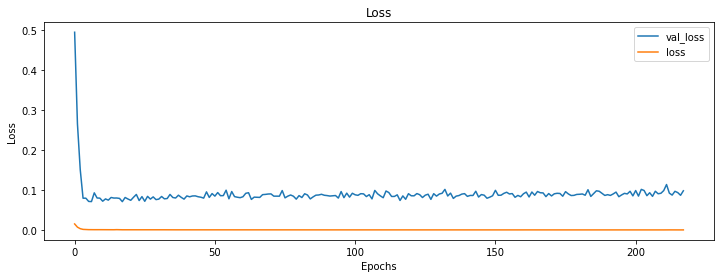

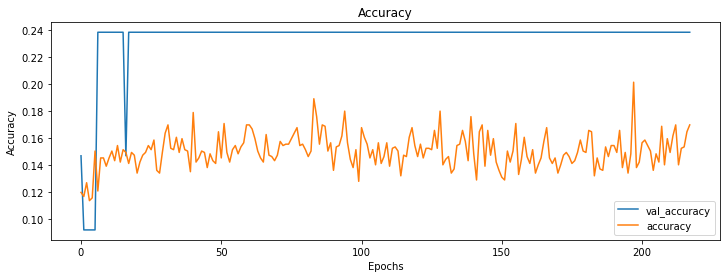

In [25]:
# Plotting Accuracy and Loss

results = res

history = results.history
plt.figure(figsize=(12,4))
plt.plot(history['val_loss'])
plt.plot(history['loss'])
plt.legend(['val_loss', 'loss'])
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

plt.figure(figsize=(12,4))
plt.plot(history['val_accuracy'])
plt.plot(history['accuracy'])
plt.legend(['val_accuracy', 'accuracy'])
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()

y_pred:
 [[34988.441671918685], [34946.240800419786], [34958.41108920411], [34997.40774063347], [34717.44080814439], [34938.56432251774], [35937.07401342749]]
y_true:
 [[34770.582031], [38705.980469], [38402.222656], [39294.199219], [38436.96875], [35697.605469], [34616.066406]]


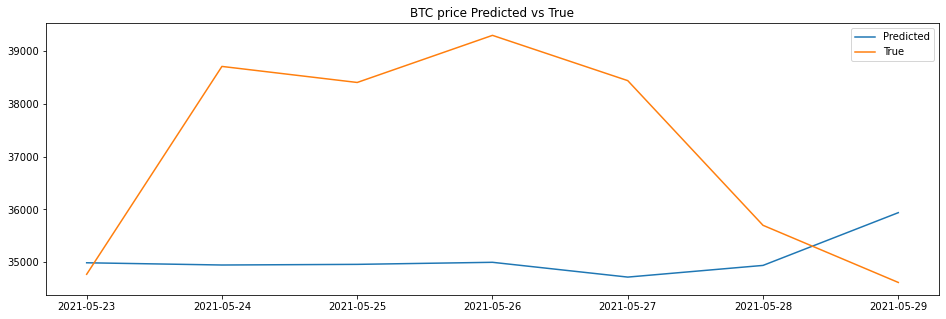

In [26]:
# Validation (validation with the last training days -> -15-15 DAYS)

# getting the predictions
y_pred = regressor.predict(X_train[-1].reshape(1, n_past, n_features)).tolist()[0]
y_pred = sc.inverse_transform(np.array(y_pred).reshape(-1,1))#.tolist()

# getting the true values
y_true = sc.inverse_transform(y_train[-1].reshape(-1,1))

print('y_pred:\n', y_pred.tolist())
print('y_true:\n', y_true.tolist())

# plotting the results
plt.figure(figsize=(16,5))
plt.plot(y_pred, label='Predicted')
plt.plot(y_true, label='True')

dates = df_train.index[-prediction_days:]
dates = [str(dates.date[i]) for i in range(len(dates))]
plt.xticks(range(prediction_days),dates)

plt.title('BTC price Predicted vs True')
plt.legend()
plt.show()

y_pred:
 [[34989.12777733717], [34947.031078912274], [34959.26961902095], [34998.15850520133], [34718.223902286954], [34939.41207580968], [35937.86429191998]]
y_true:
 [35678.128906, 37332.855469, 36684.925781, 37575.179688, 39208.765625, 36894.40625, 35746.101563]


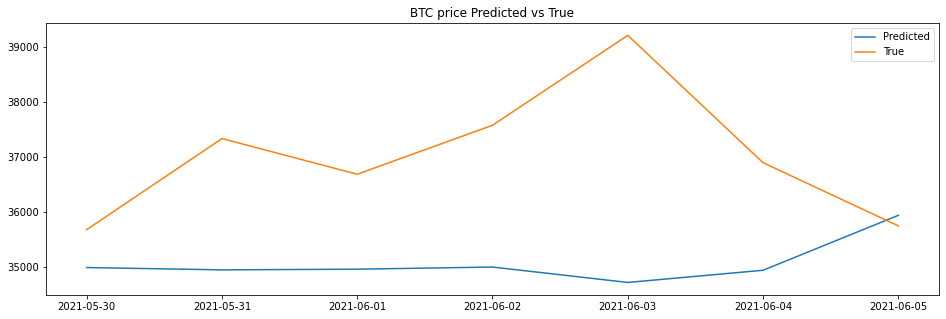

In [27]:
# Validation 2 (on the TEST SET -15 days)

# getting the predictions
x = df['Close'][-n_past-prediction_days:-prediction_days].values.reshape(-1,1)
x = sc.transform(x)
y_pred = regressor.predict(x.reshape(1, n_past, n_features)).tolist()[0]
y_pred = sc.inverse_transform(np.array(y_pred).reshape(-1,1))#.tolist()

# getting the true values
y_true = df['Close'][-prediction_days:].values

print('y_pred:\n', y_pred.tolist())
print('y_true:\n', y_true.tolist())

# plotting the results
plt.figure(figsize=(16,5))
plt.plot(y_pred, label='Predicted')
plt.plot(y_true, label='True')

dates = df.index[-prediction_days:]
dates = [str(dates.date[i]) for i in range(len(dates))]
plt.xticks(range(prediction_days),dates)

plt.title('BTC price Predicted vs True')
plt.legend()
plt.show()

In [28]:
# evaluation
rmse = math.sqrt(mean_squared_error(y_true, y_pred))

In [29]:
mean_absolute_error(y_true, y_pred)

2002.1144984788011

In [30]:
explained_variance_score(y_true, y_pred)
# Best possible score is 1.0, lower values are worse.

-0.5163097545909274

y_pred:
 [[34989.05952601282], [34946.91972148833], [34959.26961902095], [34998.13695215154], [34718.252639686674], [34939.43362885948], [35937.86429191998]]
y_true:
 [35678.128906, 37332.855469, 36684.925781, 37575.179688, 39208.765625, 36894.40625, 35746.101563]


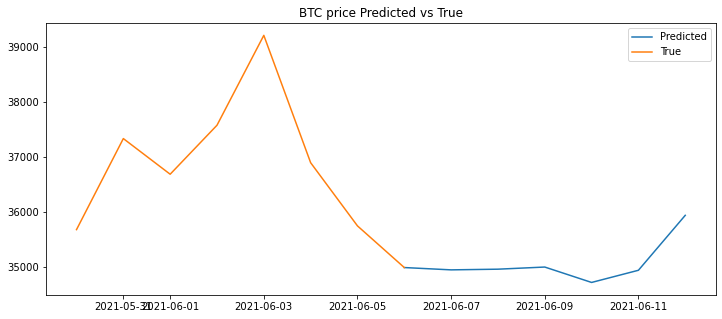

In [31]:
# Forecasting/Predicting

# getting the predictions
x = df['Close'][-n_past:].values.reshape(-1,1)
x = sc.transform(x)
y_pred = regressor.predict(x.reshape(1, n_past, n_features)).tolist()[0]
y_pred = sc.inverse_transform(np.array(y_pred).reshape(-1,1))#.tolist()

# creating a DF of the predicted prices
y_pred_df = pd.DataFrame(y_pred, 
                         index=pd.date_range(start=df.index[-1]+datetime.timedelta(days=1),
                                             periods=len(y_pred), 
                                             freq="D"), 
                         columns=df.columns)

# getting the true values
y_true_df = df.tail(prediction_days)

# linking them
y_true_df = y_true_df.append(y_pred_df.head(1))

print('y_pred:\n', y_pred.tolist())
print('y_true:\n', y_true.tolist())

# plotting the results
plt.figure(figsize=(12,5))
plt.plot(y_pred_df, label='Predicted')
plt.plot(y_true_df, label='True')

#dates = df.index[-prediction_days:]
#dates = [str(dates.date[i]) for i in range(len(dates))]
#plt.xticks(range(prediction_days),dates)

plt.title('BTC price Predicted vs True')
plt.legend()
plt.show()

In [32]:
regressor.save('regressor.h5')
#loaded_regressor = load_model('regressor.h5')
#loaded_regressor.predict(new_x)